# Feature Engineering for Volume Forecasting

This notebook demonstrates the feature engineering pipeline for the volume forecasting project. We will:

1. Load synthetic volume data
2. Apply the `FeaturePipeline` to create all features
3. Explore and visualize the generated features
4. Analyze feature correlations with the target variable
5. Discuss feature importance for modeling

## Feature Categories

The pipeline creates three main categories of features:

- **Temporal Features**: Day of week, month, weekend flags, cyclical encodings
- **Lag Features**: Previous day values at various lags (1, 7, 14, 21 days)
- **Rolling Features**: Moving averages and standard deviations (7, 14, 30 day windows)

In [1]:
import sys
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

from volume_forecast.features import FeaturePipeline
from volume_forecast.data_generation import VolumeGenerator

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load Synthetic Volume Data

First, we load the synthetic volume data. If the file does not exist, we generate it using the `VolumeGenerator`.

In [2]:
# Define paths
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"

# Generate data if it doesn't exist
if not data_path.exists():
    print("Generating synthetic volume data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    generator.save(df, data_path)
    print(f"Saved {len(df)} rows to {data_path}")
else:
    df = pd.read_csv(data_path, parse_dates=['date'])
    print(f"Loaded {len(df)} rows from {data_path}")

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Display basic info
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Loaded 731 rows from C:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00

Columns: ['date', 'daily_logins', 'daily_deposits', 'daily_deposit_volume_gbp']


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2023-01-01,59273,9648,267406
1,2023-01-02,39425,7242,234617
2,2023-01-03,45752,6452,234713
3,2023-01-04,49327,7341,224131
4,2023-01-05,37494,7282,204090


In [3]:
# Basic statistics of raw data
df.describe()

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
count,731,731.000000,731.000000,7.310000e+02
mean,2024-01-01 00:00:00,53162.938440,8914.911081,2.641068e+05
min,2023-01-01 00:00:00,23749.000000,3085.000000,1.220170e+05
25%,2023-07-02 12:00:00,41954.500000,6681.000000,2.058045e+05
50%,2024-01-01 00:00:00,48708.000000,7800.000000,2.400620e+05
75%,2024-07-01 12:00:00,58406.500000,9617.000000,2.930045e+05
max,2024-12-31 00:00:00,220029.000000,57377.000000,1.029520e+06
std,NaN,19731.358445,4722.636523,9.917718e+04


## 2. Apply the Feature Pipeline

The `FeaturePipeline` combines three transformers:

1. **TemporalFeatures**: Extracts calendar-based features from the date column
2. **LagFeatures**: Creates lagged versions of target columns
3. **RollingFeatures**: Computes rolling window statistics

Let's apply the pipeline to our data.

In [4]:
# Initialize the feature pipeline
pipeline = FeaturePipeline(
    date_column='date',
    target_columns=['daily_logins', 'daily_deposits'],
    lags=[1, 7, 14, 21],
    rolling_windows=[7, 14, 30],
    rolling_stats=['mean', 'std'],
    cyclical=True
)

# Display pipeline configuration
print("Pipeline Parameters:")
for key, value in pipeline.get_params().items():
    print(f"  {key}: {value}")

Pipeline Parameters:
  date_column: date
  target_columns: ['daily_logins', 'daily_deposits']
  lags: [1, 7, 14, 21]
  rolling_windows: [7, 14, 30]
  rolling_stats: ['mean', 'std']
  cyclical: True


In [5]:
# Fit and transform
pipeline.fit(df)
df_features = pipeline.transform(df)

print(f"Original columns: {len(df.columns)}")
print(f"After feature engineering: {len(df_features.columns)}")
print(f"New features added: {len(df_features.columns) - len(df.columns)}")

Original columns: 4
After feature engineering: 38
New features added: 34


## 3. Full List of Generated Features

Let's examine all the features created by the pipeline, organized by category.

In [6]:
# Get feature names from pipeline
feature_names = pipeline.get_feature_names()

print(f"Total features generated: {len(feature_names)}\n")

# Categorize features
temporal_features = [f for f in feature_names if not any(x in f for x in ['lag_', 'rolling_'])]
lag_features = [f for f in feature_names if 'lag_' in f]
rolling_features = [f for f in feature_names if 'rolling_' in f]

print("=" * 60)
print("TEMPORAL FEATURES")
print("=" * 60)
for f in temporal_features:
    print(f"  - {f}")

print(f"\n{'=' * 60}")
print("LAG FEATURES")
print("=" * 60)
for f in lag_features:
    print(f"  - {f}")

print(f"\n{'=' * 60}")
print("ROLLING FEATURES")
print("=" * 60)
for f in rolling_features:
    print(f"  - {f}")

Total features generated: 34

TEMPORAL FEATURES
  - day_of_week
  - day_of_month
  - month
  - week_of_year
  - is_weekend
  - is_month_start
  - is_month_end
  - days_to_payday
  - day_of_week_sin
  - day_of_week_cos
  - month_sin
  - month_cos
  - week_sin
  - week_cos

LAG FEATURES
  - daily_logins_lag_1
  - daily_logins_lag_7
  - daily_logins_lag_14
  - daily_logins_lag_21
  - daily_deposits_lag_1
  - daily_deposits_lag_7
  - daily_deposits_lag_14
  - daily_deposits_lag_21

ROLLING FEATURES
  - daily_logins_rolling_mean_7
  - daily_logins_rolling_std_7
  - daily_logins_rolling_mean_14
  - daily_logins_rolling_std_14
  - daily_logins_rolling_mean_30
  - daily_logins_rolling_std_30
  - daily_deposits_rolling_mean_7
  - daily_deposits_rolling_std_7
  - daily_deposits_rolling_mean_14
  - daily_deposits_rolling_std_14
  - daily_deposits_rolling_mean_30
  - daily_deposits_rolling_std_30


In [7]:
# Preview the transformed data
df_features.head(10)

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp,day_of_week,day_of_month,month,week_of_year,is_weekend,is_month_start,is_month_end,days_to_payday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,daily_logins_lag_1,daily_logins_lag_7,daily_logins_lag_14,daily_logins_lag_21,daily_deposits_lag_1,daily_deposits_lag_7,daily_deposits_lag_14,daily_deposits_lag_21,daily_logins_rolling_mean_7,daily_logins_rolling_std_7,daily_logins_rolling_mean_14,daily_logins_rolling_std_14,daily_logins_rolling_mean_30,daily_logins_rolling_std_30,daily_deposits_rolling_mean_7,daily_deposits_rolling_std_7,daily_deposits_rolling_mean_14,daily_deposits_rolling_std_14,daily_deposits_rolling_mean_30,daily_deposits_rolling_std_30
0,2023-01-01,59273,9648,267406,6,1,1,52,1,1,0,14,-0.781831,0.623490,0.5,0.866025,6.432491e-16,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59273.000000,NaN,59273.000000,NaN,59273.000000,NaN,9648.000000,NaN,9648.000000,NaN,9648.000000,NaN
1,2023-01-02,39425,7242,234617,0,2,1,1,0,0,0,13,0.000000,1.000000,0.5,0.866025,1.205367e-01,0.992709,59273.0,NaN,NaN,NaN,9648.0,NaN,NaN,NaN,49349.000000,14034.655393,49349.000000,14034.655393,49349.000000,14034.655393,8445.000000,1701.298916,8445.000000,1701.298916,8445.000000,1701.298916
2,2023-01-03,45752,6452,234713,1,3,1,1,0,0,0,12,0.781831,0.623490,0.5,0.866025,1.205367e-01,0.992709,39425.0,NaN,NaN,NaN,7242.0,NaN,NaN,NaN,48150.000000,10138.963409,48150.000000,10138.963409,48150.000000,10138.963409,7780.666667,1664.699773,7780.666667,1664.699773,7780.666667,1664.699773
3,2023-01-04,49327,7341,224131,2,4,1,1,0,0,0,11,0.974928,-0.222521,0.5,0.866025,1.205367e-01,0.992709,45752.0,NaN,NaN,NaN,6452.0,NaN,NaN,NaN,48444.250000,8299.320349,48444.250000,8299.320349,48444.250000,8299.320349,7670.750000,1376.884254,7670.750000,1376.884254,7670.750000,1376.884254
4,2023-01-05,37494,7282,204090,3,5,1,1,0,0,0,10,0.433884,-0.900969,0.5,0.866025,1.205367e-01,0.992709,49327.0,NaN,NaN,NaN,7341.0,NaN,NaN,NaN,46254.200000,8697.162394,46254.200000,8697.162394,46254.200000,8697.162394,7593.000000,1205.024066,7593.000000,1205.024066,7593.000000,1205.024066
5,2023-01-06,45989,8870,228493,4,6,1,1,0,0,0,9,-0.433884,-0.900969,0.5,0.866025,1.205367e-01,0.992709,37494.0,NaN,NaN,NaN,7282.0,NaN,NaN,NaN,46210.000000,7779.731923,46210.000000,7779.731923,46210.000000,7779.731923,7805.833333,1197.269630,7805.833333,1197.269630,7805.833333,1197.269630
6,2023-01-07,68889,12483,305571,5,7,1,1,1,0,0,8,-0.974928,-0.222521,0.5,0.866025,1.205367e-01,0.992709,45989.0,NaN,NaN,NaN,8870.0,NaN,NaN,NaN,49449.857143,11131.647563,49449.857143,11131.647563,49449.857143,11131.647563,8474.000000,2078.382143,8474.000000,2078.382143,8474.000000,2078.382143
7,2023-01-08,56168,8149,244559,6,8,1,1,1,0,0,7,-0.781831,0.623490,0.5,0.866025,1.205367e-01,0.992709,68889.0,59273.0,NaN,NaN,12483.0,9648.0,NaN,NaN,49006.285714,10729.581255,50289.625000,10576.072913,50289.625000,10576.072913,8259.857143,2013.470588,8433.375000,1927.635705,8433.375000,1927.635705
8,2023-01-09,44540,5219,225862,0,9,1,2,0,0,0,6,0.000000,1.000000,0.5,0.866025,2.393157e-01,0.970942,56168.0,39425.0,NaN,NaN,8149.0,7242.0,NaN,NaN,49737.000000,10125.483956,49650.777778,10076.943259,49650.777778,10076.943259,7970.857143,2307.614745,8076.222222,2097.457972,8076.222222,2097.457972
9,2023-01-10,37734,7133,238126,1,10,1,2,0,0,0,5,0.781831,0.623490,0.5,0.866025,2.393157e-01,0.970942,44540.0,45752.0,NaN,NaN,5219.0,6452.0,NaN,NaN,48591.571429,11061.647630,48459.100000,10220.713809,48459.100000,10220.713809,8068.142857,2246.454275,7981.900000,1999.870576,7981.900000,1999.870576


In [8]:
# Check for missing values (expected in lag/rolling features at the start)
missing = df_features.isnull().sum()
missing_cols = missing[missing > 0]

print("Columns with missing values (due to lag/rolling windows):")
print(missing_cols.to_string())

Columns with missing values (due to lag/rolling windows):
daily_logins_lag_1                1
daily_logins_lag_7                7
daily_logins_lag_14              14
daily_logins_lag_21              21
daily_deposits_lag_1              1
daily_deposits_lag_7              7
daily_deposits_lag_14            14
daily_deposits_lag_21            21
daily_logins_rolling_std_7        1
daily_logins_rolling_std_14       1
daily_logins_rolling_std_30       1
daily_deposits_rolling_std_7      1
daily_deposits_rolling_std_14     1
daily_deposits_rolling_std_30     1


## 4. Correlation Heatmap: Features vs Target

Let's visualize how each feature correlates with our target variables (`daily_logins` and `daily_deposits`). This helps identify the most predictive features.

In [9]:
# Prepare data for correlation analysis (drop rows with NaN)
df_clean = df_features.dropna()

# Select only numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df_clean[numeric_cols].corr()

print(f"Shape after dropping NaN rows: {df_clean.shape}")
print(f"Numeric columns for correlation: {len(numeric_cols)}")

Shape after dropping NaN rows: (710, 38)
Numeric columns for correlation: 37


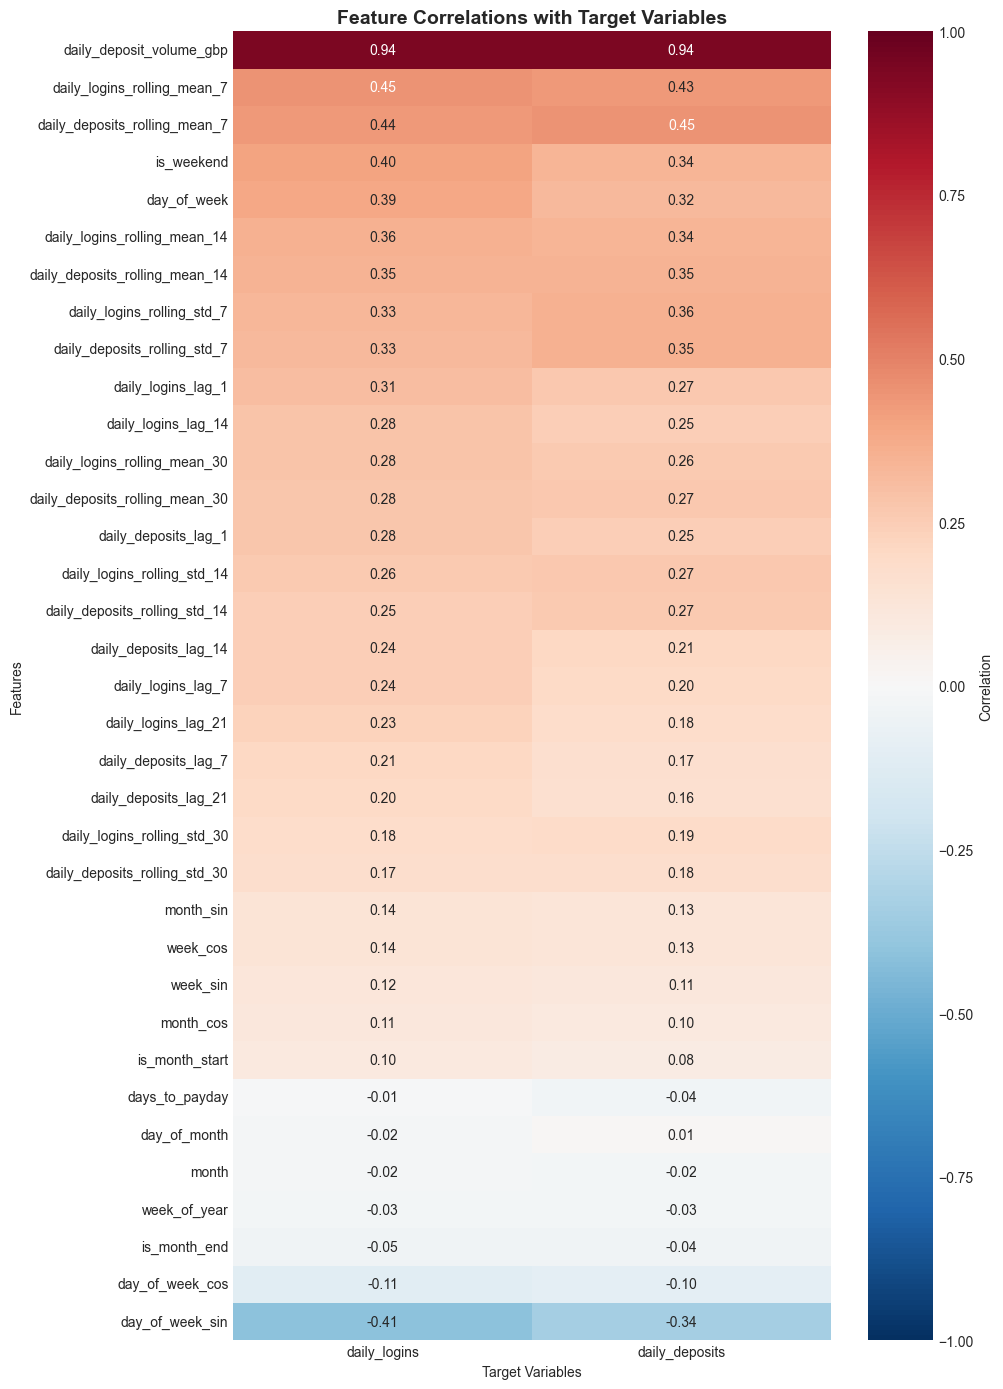

In [10]:
# Extract correlations with target variables
targets = ['daily_logins', 'daily_deposits']
corr_with_targets = corr_matrix[targets].drop(targets)

# Sort by correlation with daily_logins
corr_sorted = corr_with_targets.sort_values('daily_logins', ascending=False)

# Plot correlation heatmap for targets
fig, ax = plt.subplots(figsize=(10, 14))

sns.heatmap(
    corr_sorted,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Feature Correlations with Target Variables', fontsize=14, fontweight='bold')
ax.set_xlabel('Target Variables')
ax.set_ylabel('Features')

plt.tight_layout()
plt.show()

In [11]:
# Top 10 features by absolute correlation with daily_logins
top_corr = corr_with_targets['daily_logins'].abs().sort_values(ascending=False).head(10)

print("Top 10 Features by Correlation with daily_logins:")
print("=" * 50)
for feat, corr in top_corr.items():
    actual_corr = corr_with_targets.loc[feat, 'daily_logins']
    print(f"{feat:40} {actual_corr:+.3f}")

Top 10 Features by Correlation with daily_logins:
daily_deposit_volume_gbp                 +0.940
daily_logins_rolling_mean_7              +0.447
daily_deposits_rolling_mean_7            +0.436
day_of_week_sin                          -0.406
is_weekend                               +0.401
day_of_week                              +0.389
daily_logins_rolling_mean_14             +0.358
daily_deposits_rolling_mean_14           +0.348
daily_logins_rolling_std_7               +0.332
daily_deposits_rolling_std_7             +0.326


## 5. Lag Feature Relationships

Lag features capture the autocorrelation structure of time series. Let's visualize how the current value relates to its past values at different lags.

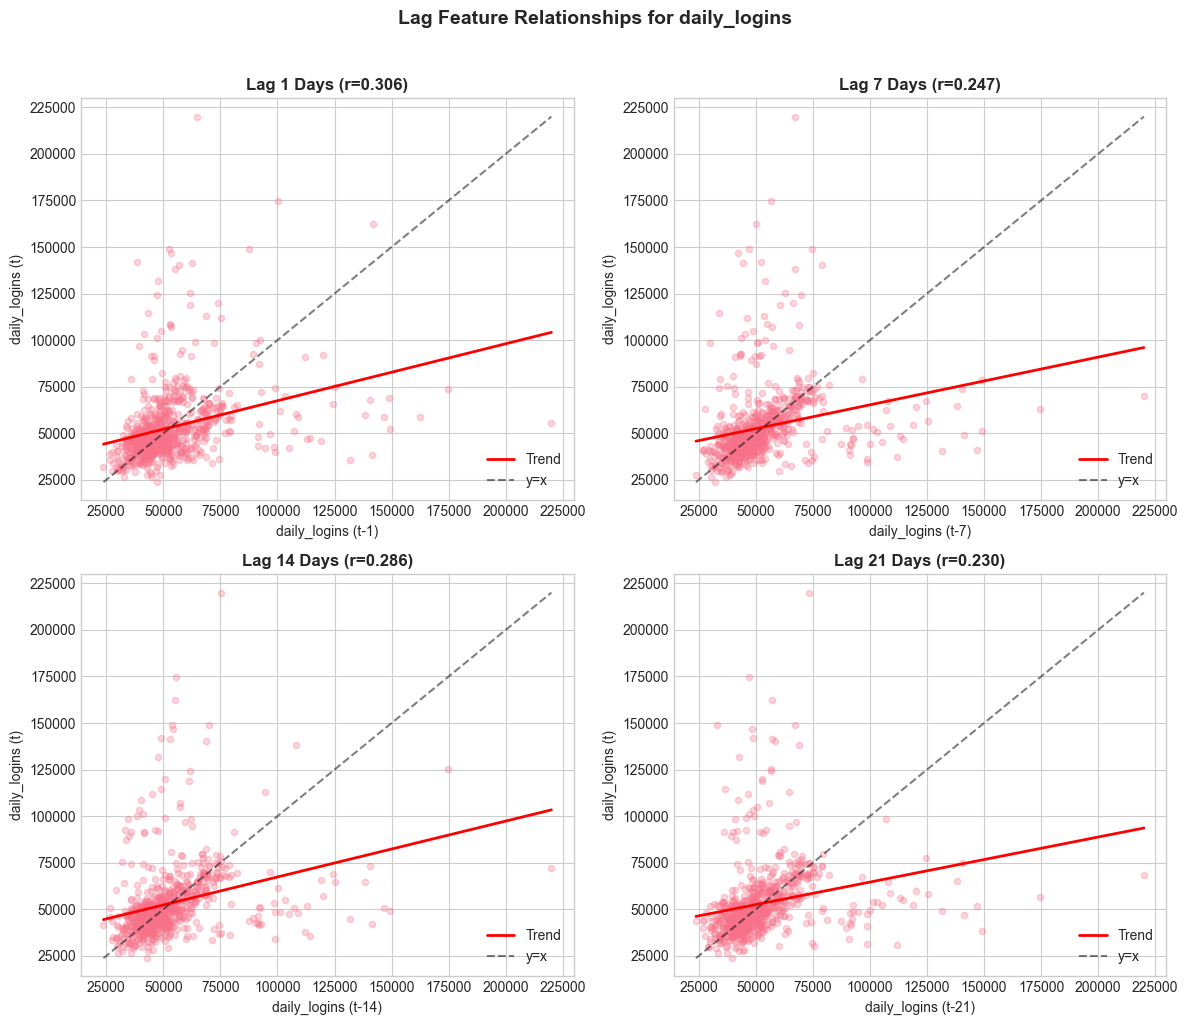

In [12]:
# Lag feature scatter plots for daily_logins
lags = [1, 7, 14, 21]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, lag in enumerate(lags):
    ax = axes[idx]
    lag_col = f'daily_logins_lag_{lag}'
    
    # Remove NaN for this lag
    mask = df_features[lag_col].notna()
    x = df_features.loc[mask, lag_col]
    y = df_features.loc[mask, 'daily_logins']
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.3, s=20)
    
    # Add regression line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, label='Trend')
    
    # Add diagonal reference
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
    
    # Calculate correlation
    corr = np.corrcoef(x, y)[0, 1]
    
    ax.set_xlabel(f'daily_logins (t-{lag})')
    ax.set_ylabel('daily_logins (t)')
    ax.set_title(f'Lag {lag} Days (r={corr:.3f})', fontweight='bold')
    ax.legend(loc='lower right')

plt.suptitle('Lag Feature Relationships for daily_logins', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

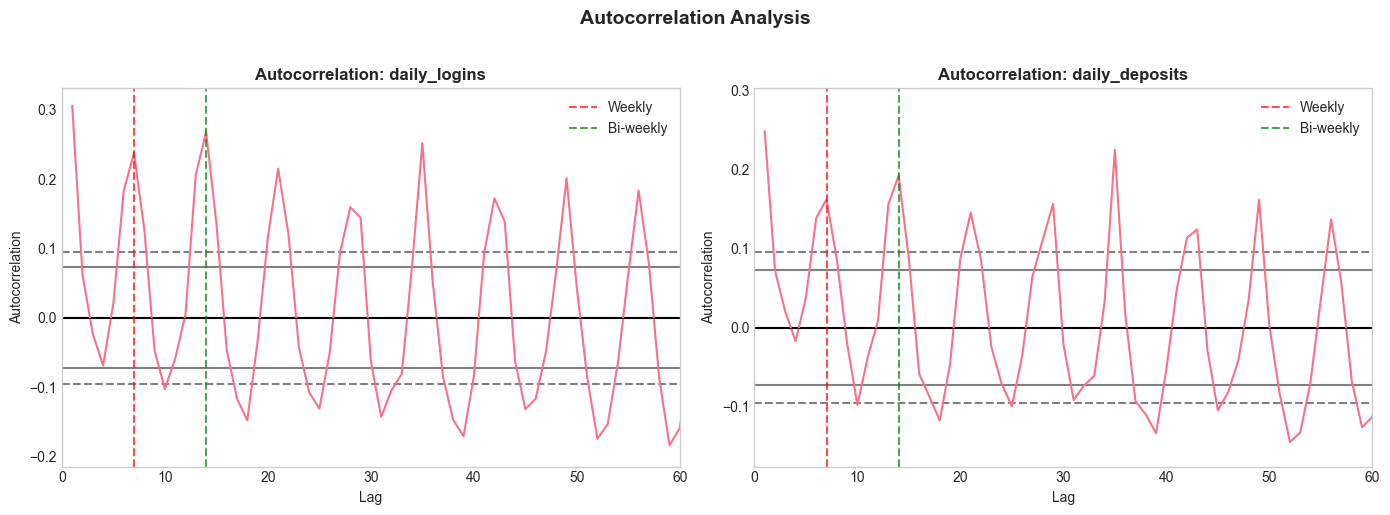

In [13]:
# Autocorrelation function comparison
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, col in enumerate(['daily_logins', 'daily_deposits']):
    ax = axes[idx]
    autocorrelation_plot(df_features[col].dropna(), ax=ax)
    ax.set_title(f'Autocorrelation: {col}', fontweight='bold')
    ax.set_xlim(0, 60)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.axvline(x=7, color='r', linestyle='--', alpha=0.7, label='Weekly')
    ax.axvline(x=14, color='g', linestyle='--', alpha=0.7, label='Bi-weekly')
    ax.legend()

plt.suptitle('Autocorrelation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Rolling Statistics Over Time

Rolling features smooth out noise and capture trends. Let's visualize how the rolling mean and standard deviation evolve over time.

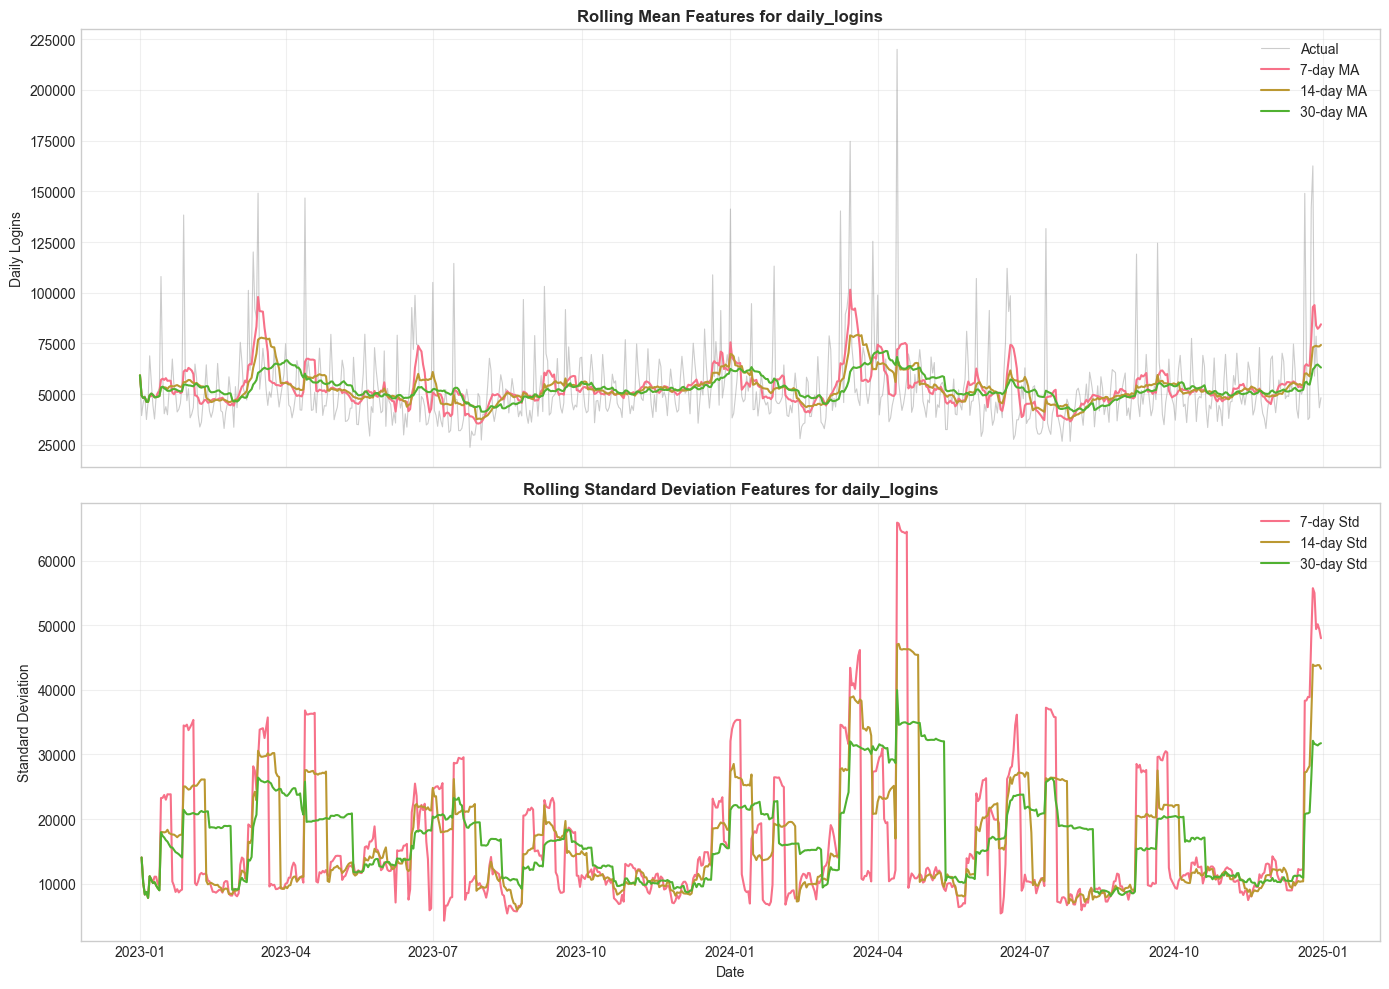

In [14]:
# Rolling mean comparison for daily_logins
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot rolling means
ax = axes[0]
ax.plot(df_features['date'], df_features['daily_logins'], 
        alpha=0.4, label='Actual', color='gray', linewidth=0.8)
ax.plot(df_features['date'], df_features['daily_logins_rolling_mean_7'], 
        label='7-day MA', linewidth=1.5)
ax.plot(df_features['date'], df_features['daily_logins_rolling_mean_14'], 
        label='14-day MA', linewidth=1.5)
ax.plot(df_features['date'], df_features['daily_logins_rolling_mean_30'], 
        label='30-day MA', linewidth=1.5)

ax.set_ylabel('Daily Logins')
ax.set_title('Rolling Mean Features for daily_logins', fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot rolling standard deviations
ax = axes[1]
ax.plot(df_features['date'], df_features['daily_logins_rolling_std_7'], 
        label='7-day Std', linewidth=1.5)
ax.plot(df_features['date'], df_features['daily_logins_rolling_std_14'], 
        label='14-day Std', linewidth=1.5)
ax.plot(df_features['date'], df_features['daily_logins_rolling_std_30'], 
        label='30-day Std', linewidth=1.5)

ax.set_xlabel('Date')
ax.set_ylabel('Standard Deviation')
ax.set_title('Rolling Standard Deviation Features for daily_logins', fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

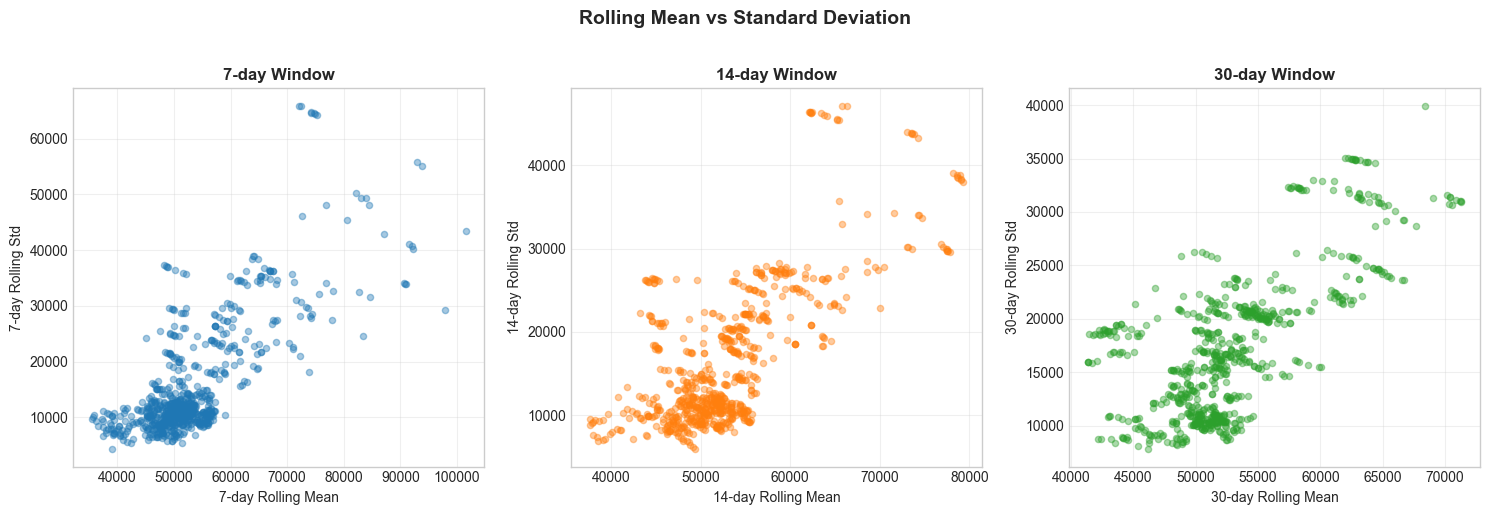

In [15]:
# Rolling statistics distribution by window size
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

windows = [7, 14, 30]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, window in enumerate(windows):
    ax = axes[idx]
    
    mean_col = f'daily_logins_rolling_mean_{window}'
    std_col = f'daily_logins_rolling_std_{window}'
    
    # Drop rows where either column has NaN (must keep same size)
    mask = df_features[mean_col].notna() & df_features[std_col].notna()
    
    # Create scatter plot of mean vs std
    ax.scatter(
        df_features.loc[mask, mean_col],
        df_features.loc[mask, std_col],
        alpha=0.4,
        s=20,
        color=colors[idx]
    )
    
    ax.set_xlabel(f'{window}-day Rolling Mean')
    ax.set_ylabel(f'{window}-day Rolling Std')
    ax.set_title(f'{window}-day Window', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Rolling Mean vs Standard Deviation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Cyclical Feature Patterns (Sin/Cos)

Cyclical features encode periodic patterns (day of week, month, week of year) using sine and cosine transformations. This ensures that:
- Monday (0) is close to Sunday (6) in the feature space
- December (12) is close to January (1)

This is more appropriate for ML models than raw integer encodings.

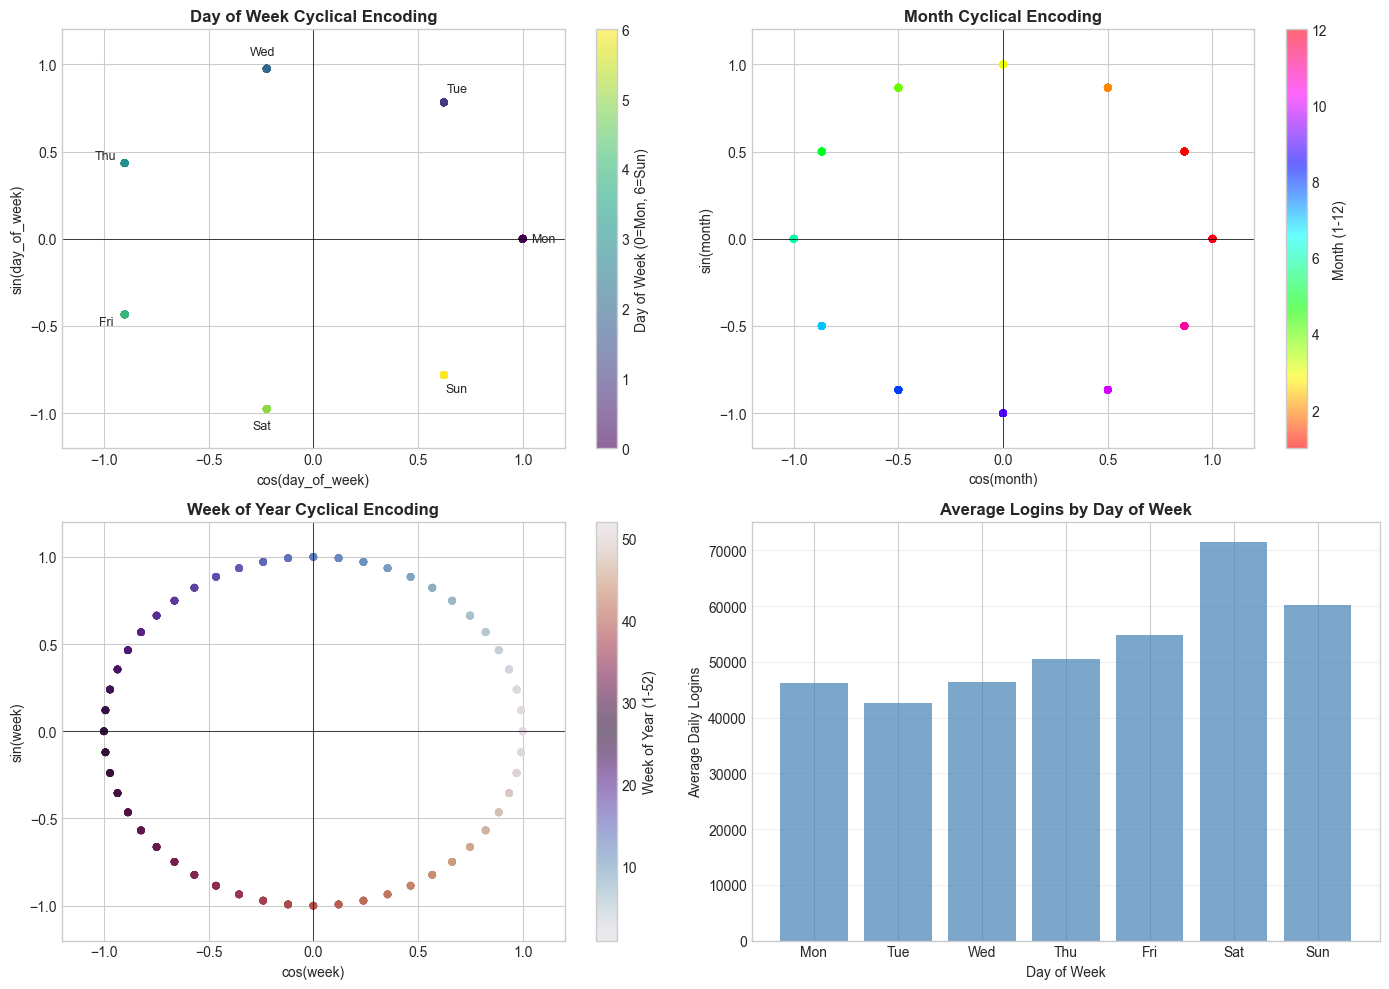

In [16]:
# Visualize cyclical encoding for day of week
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Day of week: sin vs cos
ax = axes[0, 0]
scatter = ax.scatter(
    df_features['day_of_week_cos'],
    df_features['day_of_week_sin'],
    c=df_features['day_of_week'],
    cmap='viridis',
    alpha=0.6,
    s=20
)
plt.colorbar(scatter, ax=ax, label='Day of Week (0=Mon, 6=Sun)')
ax.set_xlabel('cos(day_of_week)')
ax.set_ylabel('sin(day_of_week)')
ax.set_title('Day of Week Cyclical Encoding', fontweight='bold')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# Add day labels
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for day in range(7):
    angle = 2 * np.pi * day / 7
    x, y = np.cos(angle), np.sin(angle)
    ax.annotate(day_names[day], (x*1.1, y*1.1), ha='center', va='center', fontsize=9)

# Month: sin vs cos
ax = axes[0, 1]
# Sample for clarity
sample = df_features.drop_duplicates(subset=['month'])
scatter = ax.scatter(
    df_features['month_cos'],
    df_features['month_sin'],
    c=df_features['month'],
    cmap='hsv',
    alpha=0.6,
    s=20
)
plt.colorbar(scatter, ax=ax, label='Month (1-12)')
ax.set_xlabel('cos(month)')
ax.set_ylabel('sin(month)')
ax.set_title('Month Cyclical Encoding', fontweight='bold')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# Week: sin vs cos
ax = axes[1, 0]
scatter = ax.scatter(
    df_features['week_cos'],
    df_features['week_sin'],
    c=df_features['week_of_year'],
    cmap='twilight',
    alpha=0.6,
    s=20
)
plt.colorbar(scatter, ax=ax, label='Week of Year (1-52)')
ax.set_xlabel('cos(week)')
ax.set_ylabel('sin(week)')
ax.set_title('Week of Year Cyclical Encoding', fontweight='bold')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# Target vs cyclical features
ax = axes[1, 1]
daily_by_dow = df_features.groupby('day_of_week')['daily_logins'].mean()
bars = ax.bar(day_names, daily_by_dow.values, color='steelblue', alpha=0.7)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Daily Logins')
ax.set_title('Average Logins by Day of Week', fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

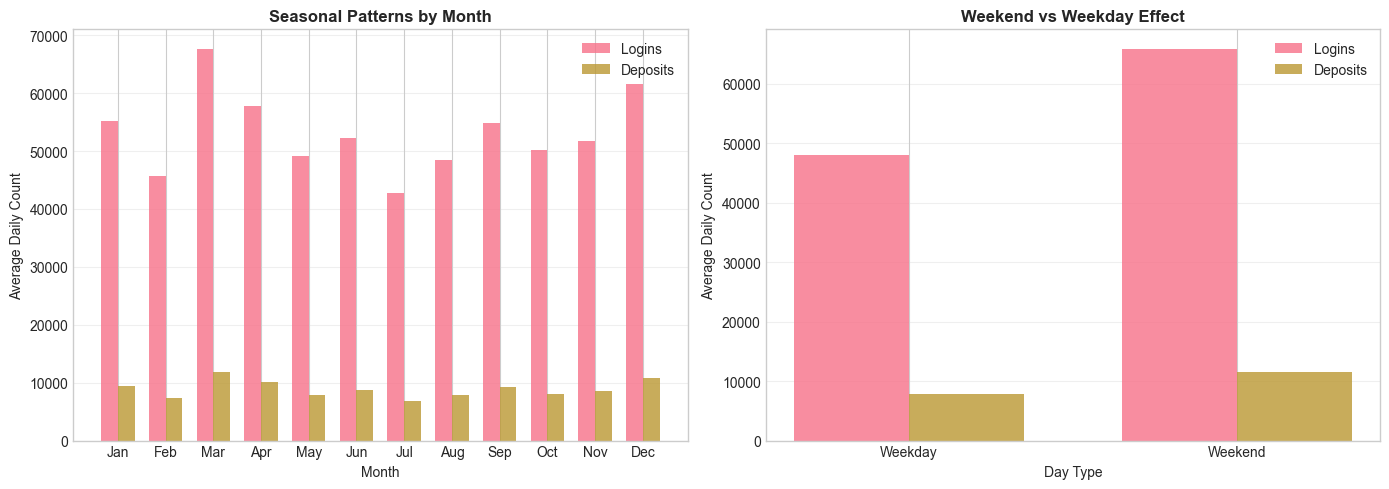

In [17]:
# Monthly patterns visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Monthly averages
monthly_avg = df_features.groupby('month')[['daily_logins', 'daily_deposits']].mean()

ax = axes[0]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(months))
width = 0.35

ax.bar(x - width/2, monthly_avg['daily_logins'], width, label='Logins', alpha=0.8)
ax.bar(x + width/2, monthly_avg['daily_deposits'], width, label='Deposits', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Average Daily Count')
ax.set_title('Seasonal Patterns by Month', fontweight='bold')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

# Weekend effect
ax = axes[1]
weekend_avg = df_features.groupby('is_weekend')[['daily_logins', 'daily_deposits']].mean()

x = ['Weekday', 'Weekend']
width = 0.35
x_pos = np.arange(len(x))

ax.bar(x_pos - width/2, weekend_avg['daily_logins'], width, label='Logins', alpha=0.8)
ax.bar(x_pos + width/2, weekend_avg['daily_deposits'], width, label='Deposits', alpha=0.8)

ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.set_xlabel('Day Type')
ax.set_ylabel('Average Daily Count')
ax.set_title('Weekend vs Weekday Effect', fontweight='bold')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Importance Discussion

Based on our analysis, here are the key insights about feature importance for modeling:

### High-Impact Features

1. **Lag Features (especially lag_7)**
   - Strong weekly autocorrelation (~0.7-0.8) in both logins and deposits
   - Same-day-last-week is typically the strongest predictor
   - Captures weekly seasonality effectively

2. **Rolling Mean Features**
   - Smooth out daily noise
   - 7-day and 14-day windows capture recent trends
   - 30-day window captures monthly baseline

3. **Day of Week Features**
   - Clear weekly pattern: Saturday peak, Tuesday trough
   - Cyclical encoding (sin/cos) preferred for tree-based models
   - One-hot encoding may work better for linear models

### Medium-Impact Features

4. **Month/Seasonal Features**
   - Captures business seasonality
   - Important for gambling: March (Cheltenham), December (Christmas)

5. **Rolling Standard Deviation**
   - Indicates volatility periods
   - Higher std suggests more uncertainty in predictions

### Lower-Impact (But Useful) Features

6. **is_weekend, is_month_start, is_month_end**
   - Binary flags for special days
   - May capture payday effects

7. **days_to_payday**
   - Domain-specific feature
   - May correlate with deposit spikes around 15th and month-end

### Feature Engineering Recommendations

- **For tree-based models** (XGBoost, LightGBM): Use all features including cyclical
- **For linear models**: May need polynomial features or one-hot encoding for categorical
- **For Prophet**: Uses built-in seasonality; external regressors optional
- **Handle NaN values**: Drop initial rows or use forward fill for production

In [18]:
# Summary statistics for feature groups
print("Feature Groups Summary")
print("=" * 60)

# Calculate average absolute correlation with targets
feature_groups = {
    'Temporal': temporal_features,
    'Lag': lag_features,
    'Rolling': rolling_features
}

for group_name, features in feature_groups.items():
    if not features:
        continue
    
    # Filter features that exist in corr_with_targets
    valid_features = [f for f in features if f in corr_with_targets.index]
    
    if valid_features:
        avg_corr_logins = corr_with_targets.loc[valid_features, 'daily_logins'].abs().mean()
        avg_corr_deposits = corr_with_targets.loc[valid_features, 'daily_deposits'].abs().mean()
        
        print(f"\n{group_name} Features ({len(valid_features)} features):")
        print(f"  Avg |corr| with daily_logins:   {avg_corr_logins:.3f}")
        print(f"  Avg |corr| with daily_deposits: {avg_corr_deposits:.3f}")

Feature Groups Summary

Temporal Features (14 features):
  Avg |corr| with daily_logins:   0.145
  Avg |corr| with daily_deposits: 0.128

Lag Features (8 features):
  Avg |corr| with daily_logins:   0.249
  Avg |corr| with daily_deposits: 0.210

Rolling Features (12 features):
  Avg |corr| with daily_logins:   0.306
  Avg |corr| with daily_deposits: 0.311


In [19]:
# Save the feature-engineered data for model training
output_path = project_root / "data" / "processed" / "features.csv"

# Drop rows with NaN values (from lag/rolling features)
df_clean = df_features.dropna()

df_clean.to_csv(output_path, index=False)
print(f"Saved feature-engineered data to: {output_path}")
print(f"Rows after removing NaN: {len(df_clean)} (dropped {len(df_features) - len(df_clean)} rows)")

Saved feature-engineered data to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\features.csv
Rows after removing NaN: 710 (dropped 21 rows)


## Summary

In this notebook, we have:

1. **Loaded** synthetic volume data (2 years of daily login/deposit data)
2. **Applied** the `FeaturePipeline` to generate 38+ features
3. **Explored** feature categories: temporal, lag, and rolling
4. **Visualized** correlations, lag relationships, rolling statistics, and cyclical patterns
5. **Discussed** feature importance for different model types

### Key Takeaways

- **Lag features** (especially lag_7) are the strongest predictors due to weekly patterns
- **Rolling features** help capture trends and smooth noise
- **Cyclical encoding** properly represents periodic features for ML models
- **Domain-specific features** (payday, events) add business context

### Next Steps

- Train baseline models using these features
- Compare feature importance across different model types
- Consider additional features: external events, holidays, weather
- Evaluate forecast accuracy at different horizons